In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean , get_MOI, get_MOI_2D, get_SHM_invariance_2D 
from invariance_functions import degree_of_freedom, get_GPR_model_2D, get_SHM_data_2D, get_double_pendulum_data, evaluate_model_future_2D, evaluate_model_grid_2D, SHM_dynamics1_2D, SHM_dynamics2_2D, get_GPR_model_GD_2D
from local_invariance_kernels import  get_polynomial_local_invariance_2D, get_SHM_local_invariance_2D, get_double_pendulum_local_invariance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6'
mean = ZeroMean(4) 

time_step = 0.01
training_time = 0.1
testing_time = 1

max_x = 5
n_train = 3
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5, (n_train))
train_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5, (n_train))

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

data2 = get_SHM_data_2D(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch

[-3.97666762 -2.23034213  0.36125877]
[-4.15399322  1.28985406  3.50600944]
[0.68468625 0.17626952 0.05968503]
[-0.5954283   0.86734004 -0.41140086]


In [5]:

#scalerX = StandardScaler().fit(data2[0])
#scalerY = StandardScaler().fit(data2[1])
scalerX = MinMaxScaler((-1,1)).fit(data2[0])
scalerY = MinMaxScaler((-1,1)).fit(data2[1])
X = scalerX.transform(data2[0])
Y = scalerY.transform(data2[1])
data = (X, Y)

In [6]:
test_starting_position1 = np.random.uniform(-max_x, max_x)
test_starting_position2 = np.random.uniform(-max_x, max_x)
test_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5)
test_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5)

print(test_starting_position1)
print(test_starting_position2)
print(test_starting_velocity1)
print(test_starting_velocity2)
test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)
time_setting = (testing_time, time_step)
scalers = (scalerX, scalerY)

-4.562958586190652
4.632303765881042
0.12364974051192013
0.6679275907836733


In [9]:
jitter = 1e-5
n_neighbours = 20
print("moi")
dynamics = (SHM_dynamics1_2D, SHM_dynamics2_2D)
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers)
print("MOI: %s"%round(moi.log_marginal_likelihood().numpy()))
print(evaluate_moi[0])
try:
    print("known")
    kernel = get_SHM_invariance_2D(1, 6, jitter) #switch
    known = get_GPR_model_2D(kernel, mean, data, iterations=1000)
    evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers)
    print("Known: %s"%round(known.log_marginal_likelihood().numpy()))
    print(evaluate_known[0])
    print("known local")
    kernel_local = get_SHM_local_invariance_2D(0.1, 1, n_neighbours, jitter) #switch
    known_local = get_GPR_model_2D(kernel_local, mean, data, iterations=1000)
    evaluate_known_local = evaluate_model_future_2D(known_local, test_starting, dynamics, time_setting, scalers)

    print("known_local: %s"%round(known_local.log_marginal_likelihood().numpy()))
    print(evaluate_known_local[0])

    polynomial_degree = 1
    print("polynomial local")
    kernel = get_polynomial_local_invariance_2D(0.1, 1, n_neighbours, jitter, polynomial_degree ) #switch
    m = get_GPR_model_GD_2D(kernel, mean, data, iterations=10, lr=0.001)
    evaluate_invariance = evaluate_model_future_2D(m, test_starting, dynamics, time_setting, scalers)
    print(kernel.poly)
    print("Learnt: %s"%round(m.log_marginal_likelihood().numpy()))
    print(evaluate_invariance[0])
    '''
    print("MOI: %s"%round(moi.log_marginal_likelihood().numpy()))
    print(evaluate_moi[0])
    print("Known: %s"%round(known.log_marginal_likelihood().numpy()))
    print(evaluate_known[0])
    '''
except tf.errors.InvalidArgumentError:
    print("jitter too small")

moi


KeyboardInterrupt: 

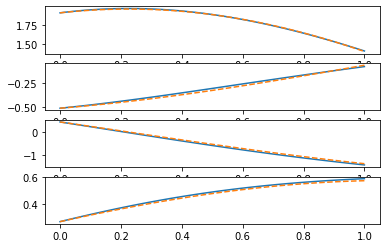

In [8]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))
fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_known_local[1][:,0])
axs[0].plot(t,evaluate_known_local[4][:,0],'--')
axs[1].plot(t,evaluate_known_local[1][:,1])
axs[1].plot(t,evaluate_known_local[4][:,1],'--')
axs[2].plot(t,evaluate_known_local[1][:,2])
axs[2].plot(t,evaluate_known_local[4][:,2],'--')
axs[3].plot(t,evaluate_known_local[1][:,3])
axs[3].plot(t,evaluate_known_local[4][:,3],'--')

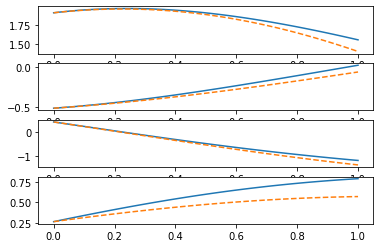

In [9]:

fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_moi[1][:,0])
axs[0].plot(t,evaluate_moi[4][:,0],'--')
axs[1].plot(t,evaluate_moi[1][:,1])
axs[1].plot(t,evaluate_moi[4][:,1],'--')
axs[2].plot(t,evaluate_moi[1][:,2])
axs[2].plot(t,evaluate_moi[4][:,2],'--')
axs[3].plot(t,evaluate_moi[1][:,3])
axs[3].plot(t,evaluate_moi[4][:,3],'--')

In [ ]:

fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_invariance[2][:,0])
axs[0].fill_between(t,evaluate_invariance[2][:,0]+1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,0]-1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_invariance[2][:,1])
axs[1].fill_between(t,evaluate_invariance[2][:,1]+1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,1]-1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_invariance[2][:,2])
axs[2].fill_between(t,evaluate_invariance[2][:,2]+1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,2]-1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_invariance[2][:,3])
axs[3].fill_between(t,evaluate_invariance[2][:,3]+1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,3]-1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')

In [ ]:


f, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,5))
t = np.linspace(0, testing_time, int(testing_time/time_step))
ax1.plot(t,evaluate_moi[1][:,0],'--',label="RBF q", color="red" )
ax1.plot(t, evaluate_moi[4][:,0], label="ground truth q", color="black")
ax1.fill_between(t,evaluate_moi[2][:,0],evaluate_moi[3][:,0], color="grey", alpha=0.5)
ax1.plot(t,evaluate_moi[1][:,1],'--',label="RBF p", color="red")
ax1.plot(t, evaluate_moi[4][:,1], label="ground truth p", color="black")
ax1.fill_between(t,evaluate_moi[2][:,1],evaluate_moi[3][:,1], color="grey", alpha=0.5)
ax1.set_xlabel("t")
ax1.set_title("RBF prediction")
ax1.legend()

ax2.plot(t,evaluate_invariance[1][:,0], '--', label="invariance q", color="blue")
ax2.plot(t, evaluate_moi[4][:,0],label="ground truth q", color="black")
ax2.fill_between(t,evaluate_invariance[2][:,0],evaluate_invariance[3][:,0], color="grey", alpha=0.5)
ax2.plot(t,evaluate_invariance[1][:,1], '--', label="invariance p", color="blue")
ax2.plot(t, evaluate_moi[4][:,1],label="ground truth p", color="black")
ax2.fill_between(t,evaluate_invariance[2][:,1],evaluate_invariance[3][:,1], color="grey", alpha=0.5)
ax2.set_xlabel("t")
ax2.set_title("Invariance prediction")
ax2.legend()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/shm_predicted_trajectory_seperate.pdf")